In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline 

import cvxopt as opt
from cvxopt import blas, solvers

import mpld3
from mpld3 import plugins

ImportError: No module named 'cvxopt'

In [102]:
## read in data
ret_df_raw= pd.read_excel( io= 'Data/cipc data.xlsx', sheetname= 'Data_Input', index_col=0)
ret_df_raw.describe()

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM,Cash
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,0.018989,0.035495,0.018274,0.027670,0.028452,0.017290,0.032061,0.008155
std,0.047757,0.070263,0.026435,0.076253,0.099660,0.091792,0.128686,0.006670
min,-0.333429,-0.214401,-0.083766,-0.219432,-0.261180,-0.211290,-0.275584,0.000000
25%,0.007742,0.004679,0.000719,-0.001749,-0.030336,-0.016548,-0.043980,0.000726
50%,0.018845,0.037985,0.017305,0.031222,0.037918,0.017968,0.038349,0.008214
75%,0.035783,0.069509,0.034229,0.070468,0.088459,0.066656,0.111489,0.013101
max,0.137135,0.264363,0.113356,0.212974,0.297346,0.258489,0.348433,0.023825


In [103]:
def cov2corr(cov, return_std=False):
    '''convert covariance matrix to correlation matrix

    Parameters
    ----------
    cov : array_like, 2d
        covariance matrix, see Notes

    Returns
    -------
    corr : ndarray (subclass)
        correlation matrix
    return_std : bool
        If this is true then the standard deviation is also returned.
        By default only the correlation matrix is returned.

    Notes
    -----
    This function does not convert subclasses of ndarrays. This requires
    that division is defined elementwise. np.ma.array and np.matrix are allowed.

    '''
    cov = np.asanyarray(cov)
    std_ = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std_, std_)
    if return_std:
        return corr, std_
    else:
        return corr


In [104]:
ret_df= ret_df_raw[['US_RE', 
                   'US_PE',
                   'US_CORP',
                   'SP500',
                   'Rusell2000',
                   'EAFE',
                   'EM']]
                   #'USGOVT10Y']]
ret_df_cov= ret_df.cov()
ret_df_corr= ret_df.corr()
N= ret_df.shape[1]
#ret_df

In [105]:
## Ledoit Wolf shrunk cov matrix


from sklearn.covariance import LedoitWolf
LW= LedoitWolf( ).fit(ret_df)
LW_alpha= LW.shrinkage_

LW_cov= pd.DataFrame(LW.covariance_)
LW_cov.index= ret_df_cov.index
LW_cov.columns= ret_df_cov.columns
LW_cov

LW_corr = pd.DataFrame(cov2corr(LW_cov))
LW_corr.index= ret_df_cov.index
LW_corr.columns= ret_df_cov.columns
LW_corr

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
US_RE,1.000000,0.296730,0.015200,0.307848,0.313075,0.260839,0.233716
US_PE,0.296730,1.000000,0.011812,0.692243,0.678817,0.611732,0.577800
US_CORP,0.015200,0.011812,1.000000,0.143748,0.079756,0.176276,0.118270
SP500,0.307848,0.692243,0.143748,1.000000,0.840865,0.771825,0.649903
Rusell2000,0.313075,0.678817,0.079756,0.840865,1.000000,0.704161,0.695298
EAFE,0.260839,0.611732,0.176276,0.771825,0.704161,1.000000,0.674103
EM,0.233716,0.577800,0.118270,0.649903,0.695298,0.674103,1.000000


In [106]:
np.sqrt(np.diagonal(np.matrix(LW_cov.values)))*2

array([ 0.09967199,  0.1412755 ,  0.06296121,  0.15254828,  0.1970037 ,
        0.18200475,  0.25263504])

In [107]:
## arithmatic avg ret to exponential avg ret 

ret_cov= np.diagonal(np.matrix(LW_cov.values))
coverter= np.array([ret_cov.tolist()]*ret_df.shape[0])* .5
ret_df_exp= ret_df- coverter


In [108]:
weight_eq= np.ones( (7,))*1.0/7
weight_peer= np.array( (0.138,0.287,0.046,0.238,0.026,0.211,0.046))
weight_peer= weight_peer/ np.sum(weight_peer)

In [109]:
## solve ERC weight 

def objective_func(w, sigma): 
    A= np.diag( w)
    B= np.diag( np.dot( sigma, w))
    C= np.diag( np.dot( A, B))/ np.dot( np.dot( w, sigma), w)- np.ones( w.size )* 1/ w.size
    
    return np.dot( C, C)


from scipy.optimize import minimize 

opt_res= minimize( objective_func, 
                 x0= weight_eq,
                 args= LW_cov,
                 method= 'Powell',
                 options= {'disp': True},
                 bounds= [[0,None]]*7,
                 tol= 1e-16)

weight_erc = opt_res.x/ np.sum( opt_res.x)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 1255


C:\Users\X197066\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


In [110]:
objective_func( weight_erc, LW_cov)

2.4589696100701789e-23

In [111]:
portf_weight_1= pd.DataFrame( [weight_eq, weight_peer, weight_erc], 
                             index=['weight_eq', 'weight_peer', 'weight_erc'], 
                             columns= LW_cov. columns)
portf_weight_1

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
weight_eq,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
weight_peer,0.139113,0.289315,0.046371,0.239919,0.026210,0.212702,0.046371
weight_erc,0.206808,0.105522,0.403146,0.085036,0.067863,0.074384,0.057241


In [112]:
## recover the implied expected ret based on shirinked cov matrix

rf= 179/10000
gamma= [ 1.5, 2, 2.5, 3, 3.5,4]
implied_ExpRet= {}

for w_name in portf_weight_1.index: 
    tmp_dic= {}
    for g in gamma:
        w= np.array(portf_weight_1.loc[w_name].tolist())
        tmp1= np.ones( ( N))* rf/4+ g*  np.dot( LW_cov, w)
        tmp2= np.ones( (N))*rf/4+ g* np.dot( ret_df_cov,w) 
        tmp_dic[str(g)+ '_shrunk']= tmp1
        tmp_dic[str(g)+'_unshrunk']= tmp2
    
    
    tmp= pd.DataFrame( tmp_dic, index= LW_cov.index)
    tmp= tmp- .5* np.array([np.diag(LW_cov).tolist()] *tmp.shape[1]).T
    implied_ExpRet[w_name]= tmp


In [113]:
implied_ExpRet['weight_eq']*400

,1.5_shrunk,1.5_unshrunk,2.5_shrunk,2.5_unshrunk,2_shrunk,2_unshrunk,3.5_shrunk,3.5_unshrunk,3_shrunk,3_unshrunk,4_shrunk,4_unshrunk
US_RE,2.057276,2.072893,2.566609,2.592638,2.311942,2.332765,3.075943,3.112383,2.821276,2.852511,3.330610,3.372256
US_PE,2.815033,2.906044,4.163680,4.315366,3.489357,3.610705,5.512328,5.724688,4.838004,5.020027,6.186652,6.429349
US_CORP,1.815416,1.798672,1.964498,1.936591,1.889957,1.867632,2.113579,2.074510,2.039038,2.005550,2.188120,2.143469
SP500,3.112107,3.230827,4.769211,4.967078,3.940659,4.098952,6.426316,6.703328,5.597764,5.835203,7.254868,7.571453
Rusell2000,3.062974,3.225280,5.205305,5.475816,4.134139,4.350548,7.347636,7.726352,6.276470,6.601084,8.418801,8.851619
EAFE,2.989717,3.130615,4.893718,5.128549,3.941717,4.129582,6.797720,7.126483,5.845719,6.127516,7.749721,8.125450
EM,2.517217,2.721740,5.129511,5.470382,3.823364,4.096061,7.741804,8.219024,6.435658,6.844703,9.047951,9.593346


In [114]:
implied_ExpRet['weight_erc']*400

,1.5_shrunk,1.5_unshrunk,2.5_shrunk,2.5_unshrunk,2_shrunk,2_unshrunk,3.5_shrunk,3.5_unshrunk,3_shrunk,3_unshrunk,4_shrunk,4_unshrunk
US_RE,1.898968,1.891614,2.302763,2.290507,2.100865,2.091060,2.706558,2.689400,2.504660,2.489953,2.908456,2.888846
US_PE,1.979126,2.027954,2.770502,2.851883,2.374814,2.439919,3.561879,3.675812,3.166191,3.263847,3.957567,4.087776
US_CORP,1.902505,1.836069,2.109646,1.998919,2.006076,1.917494,2.316787,2.161769,2.213216,2.080344,2.420357,2.243193
SP500,2.099504,2.169781,3.081539,3.198667,2.590522,2.684224,4.063575,4.227553,3.572557,3.713110,4.554592,4.741997
Rusell2000,1.695274,1.791495,2.925805,3.086174,2.310539,2.438834,4.156336,4.380852,3.541071,3.733513,4.771602,5.028191
EAFE,1.817711,1.902867,2.940376,3.082303,2.379043,2.492585,4.063041,4.261739,3.501708,3.672021,4.624373,4.851456
EM,0.787103,0.906078,2.245987,2.444278,1.516545,1.675178,3.704871,3.982478,2.975429,3.213378,4.434313,4.751579


In [115]:
implied_ExpRet['weight_peer']*400

,1.5_shrunk,1.5_unshrunk,2.5_shrunk,2.5_unshrunk,2_shrunk,2_unshrunk,3.5_shrunk,3.5_unshrunk,3_shrunk,3_unshrunk,4_shrunk,4_unshrunk
US_RE,2.067092,2.084087,2.582970,2.611295,2.325031,2.347691,3.098848,3.138503,2.840909,2.874899,3.356788,3.402107
US_PE,3.002597,3.073946,4.476287,4.595202,3.739442,3.834574,5.949978,6.116458,5.213132,5.355830,6.686823,6.877086
US_CORP,1.757026,1.757139,1.867181,1.867369,1.812104,1.812254,1.977336,1.977599,1.922258,1.922484,2.032413,2.032714
SP500,3.175906,3.277971,4.875542,5.045651,4.025724,4.161811,6.575179,6.813331,5.725361,5.929491,7.424997,7.697171
Rusell2000,2.912776,3.090695,4.954975,5.251507,3.933876,4.171101,6.997174,7.412318,5.976075,6.331913,8.018274,8.492724
EAFE,3.072051,3.203146,5.030943,5.249435,4.051497,4.226290,6.989834,7.295723,6.010388,6.272579,7.969280,8.318867
EM,2.099910,2.299796,4.433998,4.767141,3.266954,3.533468,6.768087,7.234487,5.601043,6.000814,7.935131,8.468160


In [49]:
## mean variance optimization, constuct efficient fronter 

CMA_ExpRet_geo= np.array( [700, 880, 325, 821, 906, 807, 903]) /10000 /4 #quarterly expected exponential ret 
LW_cov.index
CMA_ExpRet_arith= CMA_ExpRet_geo+ .5* np.diag(LW_cov)


In [119]:

def obj_func(w, sigma):
    return (np.dot(  np.dot( w, sigma), w)* .5)

def obj_func_derivative( w, sigma): 
    return (np.dot( w, sigma))


cons_eq0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*N)}
# cons_ineq0= {'type': 'ineq', 
#              'fun': lambda w: -w[0]-w[1]+ 0.5, 
#              'jac': lambda w: np.array([-1]*2+ [0]*10)}
# cons_ineq1= {'type': 'ineq',
#              'fun': lambda w: -w[2]-w[3]-w[4]-w[5]-w[6]+ 0.5,
#              'jac': lambda w: np.array([0]*2+ [-1]*5+ [0]*5)}
# cons_ineq2= {'type': 'ineq', 
#              'fun': lambda w: -w[7]-w[8]-w[9]-w[10]+ 0.5, 
#              'jac': lambda w: np.array([0]*7+ [-1]*4+ [0])}
# cons_ineq3= {'type': 'ineq', 
#             'fun': lambda w: -w[11]+ 0.5,
#             'jac': lambda w: np.array( [0]*11+ [-1])}



fronter1_w= {}
fronter1_vol= {}
fronter2_w= {}
fronter2_vol= {}

for target_ret in np.linspace(0.07, 0.1, 100 ): 
    cons_ineq4= {'type': 'eq', 
                'fun': lambda w: -np.dot(w, CMA_ExpRet_arith*4)+ target_ret,
                'jac': lambda w: -CMA_ExpRet_arith*4}

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          , cons_ineq4
          )

    MV_opt_2= minimize( obj_func, 
                    x0= weight_eq, 
                    args= (LW_cov+np.diag( np.array([0, 0, 0.0004/4, 0.0009/4, 0.0009/4, 0.0009/4, 0.0009/4]))), 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    #bounds= [[0,0.25]]+[[0, 0.4]]+[[0,None]]* (N-2),
                    bounds= [[0,0.3],[0,0.3],[0,0.0000001]]+ [[0, None]]*(N-3),
                    tol= 1e-12)  # long only+ concentration constrain

    MV_opt_1= minimize( obj_func, 
                    x0= weight_eq, 
                    args= (LW_cov+np.diag( np.array([0, 0, 0.0004/4, 0.0009/4, 0.0009/4, 0.0009/4, 0.0009/4]))), 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0,None],[0,None],[0,0.0000001]]+ [[0, None]]*(N-3),
                    tol= 1e-12)  # long only constrain
    
    fronter1_w[target_ret]= MV_opt_1.x
    fronter1_vol[target_ret]= np.sqrt(MV_opt_1.fun*2)*2
    
    fronter2_w[target_ret]= MV_opt_2.x
    fronter2_vol[target_ret]= np.sqrt(MV_opt_2.fun*2)*2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00183797511295
            Iterations: 49
            Function evaluations: 461
            Gradient evaluations: 45
Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.00124181306484
            Iterations: 101
            Function evaluations: 1012
            Gradient evaluations: 97
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00183797511296
            Iterations: 52
            Function evaluations: 473
            Gradient evaluations: 48
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 0.00124181306484
            Iterations: 94
            Function evaluations: 942
            Gradient evaluations: 90
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00183797511296
            Iterations: 83
            Function evalua

In [120]:
# fronter2_wtemp = {}
fronter_2= list( fronter2_vol.items())
fronter_2
#fronter_temp = [[x[0]-.5*x[1]**2, x[1]] for x in fronter_2]
#fronter_temp



[(0.070303030303030312, 0.12125923017934614),
 (0.08787878787878789, 0.12125923017991405),
 (0.091818181818181827, 0.11247307711245642),
 (0.078181818181818186, 0.12125923017943373),
 (0.099696969696969701, 0.13359823629972054),
 (0.09757575757575758, 0.12638385582362127),
 (0.08606060606060606, 0.12125923018025674),
 (0.081212121212121222, 0.12125923017917099),
 (0.089090909090909096, 0.11133714701822535),
 (0.071212121212121213, 0.12125923017948645),
 (0.070606060606060617, 0.12125923017927533),
 (0.091212121212121217, 0.11147295677524176),
 (0.092121212121212132, 0.11300957529587717),
 (0.078484848484848491, 0.1212592301790828),
 (0.093636363636363643, 0.1160425123628278),
 (0.086363636363636365, 0.12125923017949475),
 (0.081515151515151527, 0.12125923017991749),
 (0.07575757575757576, 0.12125923017937904),
 (0.097272727272727275, 0.12547547006679494),
 (0.070909090909090922, 0.12125923017944819),
 (0.092424242424242437, 0.11356991168724437),
 (0.078787878787878796, 0.12125923017942

In [121]:
y = 0
for x in fronter_2:
   fronter2_wtemp[y] = fronter2_w[x[0]]
   y = y + 1

writer= pd.ExcelWriter('output.xlsx') 
pd.DataFrame(fronter2_wtemp, ).T.to_excel(writer, 'Sheet1')
writer.save() 

(0.085353535353535348, 0.094556285624879874)
[  5.66559010e-01   3.27614595e-01   1.00000000e-07   6.25152482e-02
   0.00000000e+00   1.49243928e-02   2.83866534e-02]
(0.090909090909090912, 0.11100999118410571)
[  3.00000000e-01   3.00000000e-01   1.00000000e-07   2.84699322e-01
   5.28476420e-03   6.76555746e-02   4.23602387e-02]


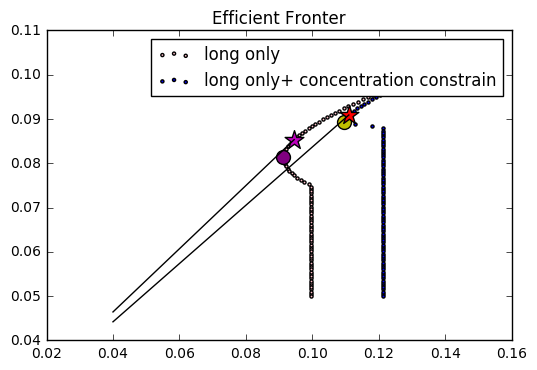

In [118]:
fronter_1= list( fronter1_vol.items())
fronter_1.sort( key=lambda x: x[1])
minvar_portf1= fronter_1[0]
minvar_portf1_w= fronter1_w[minvar_portf1[0]]
fronter_1.sort( key= lambda x: (x[0]- rf)/ x[1], reverse=True)
efficient_portf1= fronter_1[0]
efficient_portf1_w= fronter1_w[efficient_portf1[0]]

fronter_2= list(fronter2_vol.items())
fronter_2.sort(key= lambda x: x[1])
minvar_portf2= fronter_2[0]
minvar_portf2_w= fronter2_w[minvar_portf2[0]]
fronter_2.sort(key= lambda x: (x[0]-rf)/x[1], reverse= True)
efficient_portf2= fronter_2[0]
efficient_portf2_w= fronter2_w[efficient_portf2[0]]

[tmp_ret, tmp_vol]= zip( * list( fronter1_vol.items())) 
fig= plt.figure( )
plt.scatter(x= tmp_vol, y= tmp_ret, marker=".", c= 'pink' , label= 'long only')
plt.scatter(x= minvar_portf1[1], y= minvar_portf1[0], marker= 'o', c='purple', s= 100 )
plt.scatter(x= efficient_portf1[1], y = efficient_portf1[0], marker= '*', c='m', s=200)
plt.plot( [0.04, efficient_portf1[1]], [ (efficient_portf1[0]-rf)/efficient_portf1[1]* 0.04+rf, efficient_portf1[0]], 'k-')

[tmp_ret, tmp_vol]= zip(* list(fronter2_vol.items()))
plt.scatter( x= tmp_vol, y= tmp_ret, marker= '.', c='blue', label= 'long only+ concentration constrain')
plt.scatter( x= minvar_portf2[1], y=minvar_portf2[0], marker= 'o', c= 'y', s=100)
plt.scatter(x= efficient_portf2[1], y = efficient_portf2[0], marker= '*', c='r', s=200)
plt.plot( [0.04, efficient_portf2[1]], [ (efficient_portf2[0]-rf)/efficient_portf2[1]* 0.04+rf, efficient_portf2[0]], 'k-')
plt.legend()
plt.title('Efficient Fronter')

print(efficient_portf1)
print(efficient_portf1_w)
print(efficient_portf2)
print(efficient_portf2_w)

weight_longonly= efficient_portf1_w
weight_longonly_conc= efficient_portf2_w

In [26]:
portf_weight_2= pd.DataFrame([efficient_portf1_w, efficient_portf2_w], 
                             index=['CMA_weight_longonly', 'CMA_weight_longonly_conc'], columns=LW_cov.columns)
pd.concat([portf_weight_1, portf_weight_2], axis=0)

,US_RE,US_PE,US_CORP,SP500,Rusell2000,EAFE,EM
weight_eq,0.142857,0.142857,0.142857,0.142857,1.428571e-01,1.428571e-01,0.142857
weight_peer,0.139113,0.289315,0.046371,0.239919,2.620968e-02,2.127016e-01,0.046371
weight_erc,0.206808,0.105522,0.403146,0.085036,6.786336e-02,7.438370e-02,0.057241
CMA_weight_longonly,0.362450,0.234198,0.379326,0.014618,3.455894e-19,0.000000e+00,0.009407
CMA_weight_longonly_conc,0.300000,0.300000,0.300000,0.086827,7.847271e-19,2.082001e-19,0.013173


In [21]:
## risk adj return optimal long only portfolio with CMA expected ret


def obj_func_CMA(w, ARGS):  # ARGS= [sigma, ExpRet, gamma]
    return (np.dot(  np.dot( w, ARGS[0]), w)* .5* ARGS[2]- np.dot( ARGS[1], w))

def obj_func_derivative_CMA( w, ARGS): 
    return (np.dot( w, ARGS[0])* ARGS[2]- ARGS[1])


cons_eq0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*N)}
# cons_ineq0= {'type': 'ineq', 
#              'fun': lambda w: -w[0]-w[1]+ 0.5, 
#              'jac': lambda w: np.array([-1]*2+ [0]*10)}
# cons_ineq1= {'type': 'ineq',
#              'fun': lambda w: -w[2]-w[3]-w[4]-w[5]-w[6]+ 0.5,
#              'jac': lambda w: np.array([0]*2+ [-1]*5+ [0]*5)}
# cons_ineq2= {'type': 'ineq', 
#              'fun': lambda w: -w[7]-w[8]-w[9]-w[10]+ 0.5, 
#              'jac': lambda w: np.array([0]*7+ [-1]*4+ [0])}
# cons_ineq3= {'type': 'ineq', 
#             'fun': lambda w: -w[11]+ 0.5,
#             'jac': lambda w: np.array( [0]*11+ [-1])}


CMA_riskAdj_opt={}

for g in [2,2.5,3,3.5,4]: 

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          )

    MV_opt= minimize( obj_func_CMA, 
                    x0= weight_eq, 
                    args= [LW_cov, CMA_ExpRet_arith, g], 
                    jac= obj_func_derivative_CMA ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    #bounds= [[0, 0.25]]+[[0, .4]]+[[0,None]]* (N-2),
                    bounds= [[0,0.3]]* (N),
                    tol= 1e-12)
    
    CMA_riskAdj_opt[g]= MV_opt.x
    
CMA_riskAdj_portf_w= pd.DataFrame( CMA_riskAdj_opt, index=LW_cov.columns).T
CMA_riskAdj_portf_w.index= ['weight_CMA_MVO_gamma_'+str(x) for x in CMA_riskAdj_portf_w.index]
    


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0194798260073
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0184502664699
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.017475220857
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0165767919112
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0157394024998
            Iterations: 23
            Function evaluatio

In [22]:
CMA_riskAdj_portf_w

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
weight_CMA_MVO_gamma_2.0,0.3,0.3,0.000000e+00,0.000000e+00,0.180607,0.000000,0.219393
weight_CMA_MVO_gamma_2.5,0.3,0.3,0.000000e+00,3.996748e-17,0.216500,0.000000,0.183500
weight_CMA_MVO_gamma_3.0,0.3,0.3,0.000000e+00,7.599354e-02,0.161141,0.018371,0.144495
weight_CMA_MVO_gamma_3.5,0.3,0.3,9.711936e-17,1.405892e-01,0.113584,0.030060,0.115767
weight_CMA_MVO_gamma_4.0,0.3,0.3,3.582843e-02,1.621623e-01,0.077544,0.032376,0.092089


In [23]:
## Introducing active management
# Apply active management to Equity (SP500, Rusell2000, EAFE and EM), 
# assuming IR of 1/3 and active alpha 1% and hence tracking error 3%, both annualized 


LW_vol= np.sqrt(np.diag(LW_cov))
LW_corr= pd.DataFrame(np.dot(np.dot(np.diag(1/LW_vol), LW_cov), np.diag(1/LW_vol)), columns= LW_cov.columns, index=LW_cov.index)
LW_cov_active= pd.DataFrame(LW_cov+ np.diag( np.array([0, 0, 0.0009/4, 0.0009/4, 0.0009/4, 0.0009/4, 0.0009/4])),
                           index= LW_cov.index,
                           columns= LW_cov.columns)
LW_vol_active= np.sqrt(np.diag(LW_cov_active))

CMA_ExpRet_active_geo= CMA_ExpRet_geo+ np.array([0,0,0.0075/4, 0.01/4, 0.01/4, 0.01/4, 0.01/4])
CMA_ExpRet_active_arith= CMA_ExpRet_arith+ np.array( [0,0,0.0075/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4, 0.01/4+ .5* 0.0009/4 ])

LW_corr_active= pd.DataFrame(np.dot(np.dot(np.diag(1/LW_vol_active), LW_cov_active), np.diag(1/LW_vol_active)), 
                            index= LW_cov_active.index,
                            columns= LW_cov_active.columns)


In [24]:
## Fronter Construction with active management



fronter1_active_w= {}
fronter1_active_vol= {}
fronter2_active_w= {}
fronter2_active_vol= {}

for target_ret in np.linspace(0.065, 0.1, 100 ): 
    cons_ineq4_active= {'type': 'eq', 
                'fun': lambda w: -np.dot(w, CMA_ExpRet_active_arith*4)+ target_ret,
                'jac': lambda w: -CMA_ExpRet_active_arith*4}

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          , cons_ineq4_active
          )

    MV_active_opt_2= minimize( obj_func, 
                    x0= weight_eq, 
                    args= LW_cov_active, 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    #bounds= [[0,0.25]]+[[0, 0.4]]+[[0,None]]* (N-2),
                    bounds= [[0,0.3]]* (N),
                    tol= 1e-12)  # long only+ concentration constrain

    MV_active_opt_1= minimize( obj_func, 
                    x0= weight_eq, 
                    args= LW_cov_active, 
                    jac= obj_func_derivative ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0, None]]* N,
                    tol= 1e-12)  # long only constrain
    
    fronter1_active_w[target_ret]= MV_active_opt_1.x
    fronter1_active_vol[target_ret]= np.sqrt(MV_active_opt_1.fun*2) 
    
    fronter2_active_w[target_ret]= MV_active_opt_2.x
    fronter2_active_vol[target_ret]= np.sqrt(MV_active_opt_2.fun*2)
    
    
    


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00131357384918
            Iterations: 18
            Function evaluations: 116
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0020345040048
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00131357384918
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00192702470341
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00131357384918
            Iterations: 21
            Function evaluations: 121

(0.084343434343434345, 0.047081945661880828)
[  5.76958650e-01   3.92525584e-01   1.58869429e-02   0.00000000e+00
   1.51788304e-18   5.28548559e-19   1.46288226e-02]
(0.081313131313131309, 0.049596874650441915)
[  3.00000000e-01   3.00000000e-01   1.78278771e-01   1.69614120e-01
   1.53898000e-17   2.93300999e-02   2.27770094e-02]
(0.084090909090909091, 0.04634477831055471)
[  5.39163618e-01   3.12269699e-01   5.54793646e-02   5.79459741e-02
   1.75674633e-18   1.39161193e-02   2.12252243e-02]
(0.085151515151515159, 0.049807707027761085)
[  3.00000000e-01   3.00000000e-01   1.71646197e-01   1.70585862e-01
   1.43857954e-17   3.95984112e-02   1.81695300e-02]


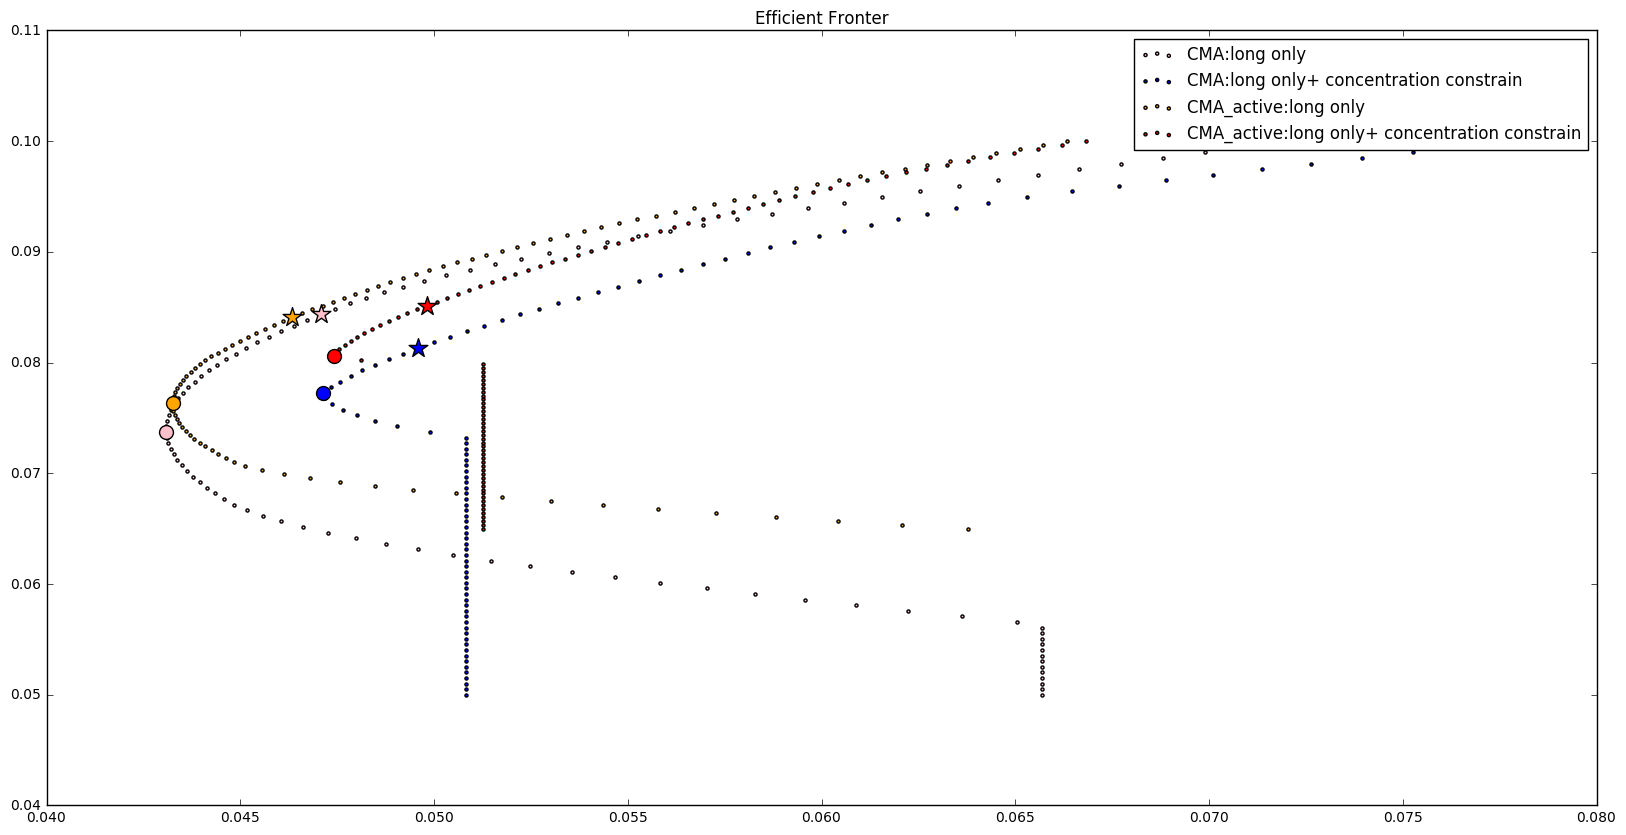

In [25]:

fronter_1= list( fronter1_vol.items())
fronter_1.sort( key=lambda x: x[1])
minvar_portf1= fronter_1[0]
minvar_portf1_w= fronter1_w[minvar_portf1[0]]
fronter_1.sort( key= lambda x: (x[0]- rf)/ x[1], reverse=True)
efficient_portf1= fronter_1[0]
efficient_portf1_w= fronter1_w[efficient_portf1[0]]

fronter_2= list(fronter2_vol.items())
fronter_2.sort(key= lambda x: x[1])
minvar_portf2= fronter_2[0]
minvar_portf2_w= fronter2_w[minvar_portf2[0]]
fronter_2.sort(key= lambda x: (x[0]-rf)/x[1], reverse= True)
efficient_portf2= fronter_2[0]
efficient_portf2_w= fronter2_w[efficient_portf2[0]]

fronter_active_1= list( fronter1_active_vol.items())
fronter_active_1.sort(key= lambda x: x[1])
minvar_active_portf1= fronter_active_1[0]
minvar_active_portf1_w= fronter1_active_w[minvar_active_portf1[0]]
fronter_active_1.sort(key= lambda x: (x[0]-rf)/x[1], reverse =True)
efficient_portf1_active= fronter_active_1[0]
efficient_portf1_active_w= fronter1_active_w[efficient_portf1_active[0]]


fronter_active_2= list( fronter2_active_vol.items())
fronter_active_2.sort( key= lambda x: x[1])
minvar_active_portf2= fronter_active_2[0]
minvar_active_portf2_w= fronter2_active_w[ minvar_active_portf2[0]]
fronter_active_2.sort(key= lambda x: (x[0]-rf)/x[1], reverse= True)
efficient_portf2_active= fronter_active_2[0]
efficient_portf2_active_w= fronter2_active_w[efficient_portf2_active[0]]


fig= plt.figure(figsize= (20,10))

[tmp_ret, tmp_vol]= zip( * list( fronter1_vol.items())) 
plt.scatter(x= tmp_vol, y= tmp_ret, marker=".", c= 'pink' , label= 'CMA:long only')
plt.scatter(x= minvar_portf1[1], y= minvar_portf1[0], marker= 'o', c='pink', s= 100 )
plt.scatter(x= efficient_portf1[1], y = efficient_portf1[0], marker= '*', c='pink', s=200)
# plt.plot( [0.04, efficient_portf1[1]], [ (efficient_portf1[0]-rf)/efficient_portf1[1]* 0.04+rf, efficient_portf1[0]], 
#          linestyle='-', c='pink')

[tmp_ret, tmp_vol]= zip(* list(fronter2_vol.items()))
plt.scatter( x= tmp_vol, y= tmp_ret, marker= '.', c='blue', label= 'CMA:long only+ concentration constrain')
plt.scatter( x= minvar_portf2[1], y=minvar_portf2[0], marker= 'o', c= 'blue', s=100)
plt.scatter(x= efficient_portf2[1], y = efficient_portf2[0], marker= '*', c='blue', s=200)
# plt.plot( [0.04, efficient_portf2[1]], [ (efficient_portf2[0]-rf)/efficient_portf2[1]* 0.04+rf, efficient_portf2[0]], 
#          linestyle= '-', c= 'blue')


[tmp_ret, tmp_vol]= zip( * list( fronter1_active_vol.items())) 
plt.scatter(x= tmp_vol, y= tmp_ret, marker=".", c= 'orange' , label= 'CMA_active:long only')
plt.scatter(x= minvar_active_portf1[1], y= minvar_active_portf1[0], marker= 'o', c='orange', s= 100 )
plt.scatter(x= efficient_portf1_active[1], y = efficient_portf1_active[0], marker= '*', c='orange', s=200)
# plt.plot( [0.04, efficient_portf1_active[1]], [ (efficient_portf1_active[0]-rf)/efficient_portf1_active[1]* 0.04+rf, efficient_portf1_active[0]], 
#          linestyle='-', c='orange')

[tmp_ret, tmp_vol]= zip(* list(fronter2_active_vol.items()))
plt.scatter( x= tmp_vol, y= tmp_ret, marker= '.', c='red', label= 'CMA_active:long only+ concentration constrain')
plt.scatter( x= minvar_active_portf2[1], y=minvar_active_portf2[0], marker= 'o', c= 'red', s=100)
plt.scatter(x= efficient_portf2_active[1], y = efficient_portf2_active[0], marker= '*', c='red', s=200)
# plt.plot( [0.04, efficient_portf2_active[1]], [ (efficient_portf2_active[0]-rf)/efficient_portf2_active[1]* 0.04+rf, efficient_portf2_active[0]], 
#          linestyle= '-', c='red')




plt.legend()
plt.title('Efficient Fronter')

print(efficient_portf1)
print(efficient_portf1_w)
print(efficient_portf2)
print(efficient_portf2_w)
print(efficient_portf1_active)
print(efficient_portf1_active_w)
print(efficient_portf2_active)
print(efficient_portf2_active_w)

weight_longonly= efficient_portf1_w
weight_longonly_conc= efficient_portf2_w

In [26]:
portf_weight_3= pd.DataFrame( [efficient_portf1_active_w, efficient_portf2_active_w],
                            index= ['CMA_active_weight_longonly', 'CMA_active_weight_longonly_conc'], 
                            columns= LW_cov.columns)

pd.concat([portf_weight_1, portf_weight_2, portf_weight_3], axis=0)

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
weight_eq,0.142857,0.142857,0.142857,0.142857,1.428571e-01,1.428571e-01,0.142857
weight_peer,0.138614,0.287129,0.049505,0.237624,2.970297e-02,2.079208e-01,0.049505
weight_erc,0.282415,0.142979,0.177851,0.118734,9.272408e-02,1.058735e-01,0.079423
CMA_weight_longonly,0.576959,0.392526,0.015887,0.000000,1.517883e-18,5.285486e-19,0.014629
CMA_weight_longonly_conc,0.300000,0.300000,0.178279,0.169614,1.538980e-17,2.933010e-02,0.022777
CMA_active_weight_longonly,0.539164,0.312270,0.055479,0.057946,1.756746e-18,1.391612e-02,0.021225
CMA_active_weight_longonly_conc,0.300000,0.300000,0.171646,0.170586,1.438580e-17,3.959841e-02,0.018170


In [27]:
## Risk adj return utility constrained optimal with active management 




def obj_func_CMAactive(w, ARGS):  # ARGS= [sigma, ExpRet, gamma]
    return (np.dot(  np.dot( w, ARGS[0]), w)* .5* ARGS[2]- np.dot( ARGS[1], w))

def obj_func_derivative_CMAactive( w, ARGS): 
    return (np.dot( w, ARGS[0])* ARGS[2]- ARGS[1])


cons_eq0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*N)}
# cons_ineq0= {'type': 'ineq', 
#              'fun': lambda w: -w[0]-w[1]+ 0.5, 
#              'jac': lambda w: np.array([-1]*2+ [0]*10)}
# cons_ineq1= {'type': 'ineq',
#              'fun': lambda w: -w[2]-w[3]-w[4]-w[5]-w[6]+ 0.5,
#              'jac': lambda w: np.array([0]*2+ [-1]*5+ [0]*5)}
# cons_ineq2= {'type': 'ineq', 
#              'fun': lambda w: -w[7]-w[8]-w[9]-w[10]+ 0.5, 
#              'jac': lambda w: np.array([0]*7+ [-1]*4+ [0])}
# cons_ineq3= {'type': 'ineq', 
#             'fun': lambda w: -w[11]+ 0.5,
#             'jac': lambda w: np.array( [0]*11+ [-1])}


CMAactive_riskAdj_opt={}
CMAactive_riskAdj_opt2={}
for g in [3,3.5,4]: 

    cons= (cons_eq0
    #        cons_ineq0,
    #        cons_ineq1,
    #        cons_ineq2,
    #        cons_ineq3
          )

    MV_opt= minimize( obj_func_CMAactive, 
                    x0= weight_eq, 
                    args= [LW_cov_active, CMA_ExpRet_active_arith, g], 
                    jac= obj_func_derivative_CMAactive ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    #bounds= [[0, 0.25]]+[[0, .4]]+[[0,None]]* (N-2),
                    bounds= [[0,0.3]]* (N),
                    tol= 1e-12)

    MV_opt2= minimize( obj_func_CMAactive, 
                    x0= weight_eq, 
                    args= [LW_cov_active, CMA_ExpRet_active_arith, g], 
                    jac= obj_func_derivative_CMAactive ,
                    method= 'SLSQP',
                    options= {'disp': True},
                    constraints= cons, 
                    bounds= [[0,None]]* N,
                    tol= 1e-12)
    
    CMAactive_riskAdj_opt[g]= MV_opt.x
    CMAactive_riskAdj_opt2[g]= MV_opt2.x
    
CMAactive_riskAdj_portf_w= pd.DataFrame( CMAactive_riskAdj_opt, index=LW_cov_active.columns).T
CMAactive_riskAdj_portf_w.index= ['weight_CMAactive_MVO_gamma_'+str(x) for x in CMAactive_riskAdj_portf_w.index]
CMAactive_riskAdj_portf_w2= pd.DataFrame( CMAactive_riskAdj_opt2, index= LW_cov_active.columns).T
CMAactive_riskAdj_portf_w2.index= ['weight_CMAactive_MVO_gamma_'+str(x)+'uncons' for x in CMAactive_riskAdj_portf_w.index]
CMAactive_riskAdj_portf_w


Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0185026477575
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0186737278728
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0176035904487
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.017893465271
            Iterations: 36
            Function evaluations: 37
            Gradient evaluations: 36
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.016750084655
            Iterations: 32
            Function evaluation

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
weight_CMAactive_MVO_gamma_3.0,0.3,0.3,0.000000,0.078008,0.155415,0.023572,0.143006
weight_CMAactive_MVO_gamma_3.5,0.3,0.3,0.000000,0.133980,0.114633,0.036827,0.114561
weight_CMAactive_MVO_gamma_4.0,0.3,0.3,0.010328,0.168906,0.083499,0.044666,0.092601


In [28]:
  #pd.DataFrame(CMAactive_riskAdj_opt[2],)

In [29]:
portf_weight= pd.concat( [portf_weight_1, 
                          portf_weight_2, 
                          CMA_riskAdj_portf_w.iloc[ -3:] ,
                          portf_weight_3, 
                          CMAactive_riskAdj_portf_w,
                         CMAactive_riskAdj_portf_w2], axis= 0 )
portf_weight.index= ['w_eq', # equal weight 
                    'w_peer', # peer weight
                    'w_erc', # equal risk contribution weight 
                    'w_MVO_1', # mean-variance optimal weight with long only constrain
                    'w_MVO_2', # mean-variance optimal weight with long only+ concentration constrain
                    'w_RUO_3', # risk adj utility optimal weight with long only+ concentration constrain, give risk aversion 3 
                    'w_RUO_3.5', # risk adj utility optimal weight with long only+ concentration constrain, given risk aversion 3.5
                    'w_RUO_4', # risk adj utility optimal weight with long only+ concentration constrain, give risk aversion 4
                    'w_aMVO_1', # mean-variance optimal weight with long only constrain, and active management 
                    'w_aMVO_2', # mean-variance optimal weight with long only+ concentration constrain, and active management 
                    'w_aRUO_3', # risk adj utility optimal weight with long only+ concentration constrain, and active management, give risk aversion 3 
                    'w_aRUO_3.5', # risk adj utility optimal weight with long only+ concentration constrain, and active management, give risk aversion 3.5 
                    'w_aRUO_4', # risk adj utility optimal weight with long only+ concentration constrain, and active management, give risk aversion 4
                    'w_aRUO_3unc',
                    'w_aRUO_3.5unc',
                    'w_aRUO_4unc'] 
portf_weight

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
w_eq,0.142857,0.142857,1.428571e-01,1.428571e-01,1.428571e-01,1.428571e-01,0.142857
w_peer,0.138614,0.287129,4.950495e-02,2.376238e-01,2.970297e-02,2.079208e-01,0.049505
w_erc,0.282415,0.142979,1.778511e-01,1.187341e-01,9.272408e-02,1.058735e-01,0.079423
w_MVO_1,0.576959,0.392526,1.588694e-02,0.000000e+00,1.517883e-18,5.285486e-19,0.014629
w_MVO_2,0.300000,0.300000,1.782788e-01,1.696141e-01,1.538980e-17,2.933010e-02,0.022777
w_RUO_3,0.300000,0.300000,0.000000e+00,7.599354e-02,1.611408e-01,1.837060e-02,0.144495
w_RUO_3.5,0.300000,0.300000,9.711936e-17,1.405892e-01,1.135842e-01,3.005979e-02,0.115767
w_RUO_4,0.300000,0.300000,3.582843e-02,1.621623e-01,7.754428e-02,3.237553e-02,0.092089
w_aMVO_1,0.539164,0.312270,5.547936e-02,5.794597e-02,1.756746e-18,1.391612e-02,0.021225
w_aMVO_2,0.300000,0.300000,1.716462e-01,1.705859e-01,1.438580e-17,3.959841e-02,0.018170


In [30]:
ExpRet=  pd.concat([implied_ExpRet['weight_eq'][['3_shrunk', '3.5_shrunk', '4_shrunk']].T, 
                   implied_ExpRet['weight_peer'][['3_shrunk', '3.5_shrunk', '4_shrunk']].T,
                   implied_ExpRet['weight_erc'][['3_shrunk', '3.5_shrunk', '4_shrunk']].T,
                   pd.DataFrame([CMA_ExpRet_geo,CMA_ExpRet_active_geo], columns= LW_cov.columns)], 
                   axis=0)* 400
ExpRet.index= ['iRet_eq_3', # implied expected return from equal weight with risk aversion 3
               'iRet_eq_3.5', # implied expected return from equal weight with risk aversion 3.5
               'iRet_eq_4',
               'iRet_peer_3', # implied expected return from peer weight with risk aversion 3
               'iRet_peer_3.5', # implied expected return from peer weight with risk aversion 3.5
               'iRet_peer_4',
               'iRet_erc_3', # implied expected return from equal risk contribution weight with risk aversion 3
               'iRet_erc_3.5',# implied expected return from equal risk contribution weight with risk aversion 3.5
               'iRet_erc_4',
               'CMA', # CMA expected return 
               'CMA_active' # CMA expected return, and active management
              ]

ExpRet # annualized expected ret in percentage 

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
iRet_eq_3,2.946497,5.112730,4.197299,5.940288,6.745272,6.198200,6.975123
iRet_eq_3.5,3.223899,5.834154,4.742391,6.827058,7.894844,7.209535,8.370075
iRet_eq_4,3.501302,6.555578,5.287484,7.713828,9.044416,8.220869,9.765026
iRet_peer_3,2.875835,5.296642,3.655122,5.827752,6.117100,6.102522,5.785744
iRet_peer_3.5,3.141460,6.048718,4.109852,6.695766,7.161977,7.097910,6.982466
iRet_peer_4,3.407086,6.800794,4.564582,7.563779,8.206854,8.093298,8.179187
iRet_erc_3,3.116898,4.408355,3.840304,4.983875,5.436244,5.024522,5.129680
iRet_erc_3.5,3.422701,5.012383,4.325897,5.711243,6.367644,5.840244,6.217058
iRet_erc_4,3.728504,5.616411,4.811491,6.438610,7.299045,6.655965,7.304435
CMA,7.000000,8.800000,4.770000,7.210000,8.060000,7.070000,8.030000


### Black-Litterman Framework 

Construct BL framework to incorporate benchmark(prior) and views(observations) and produce a reasonable distribution of expected return (posterior). 
Apply mean-variance optimization based on posterior to achieve optimal allocation. 

#### Benckmark/Equilibrium Portfolio

Set the benchmark as peer holding `w_peer`, then `iRet_peer_3.5` is the implied equilibrium\benchmark expected return, given risk aversion factor 3.5.

#### The prior confidence  $\tau$

Follow BL's initial setting, $\tau = 0.05$

#### Views

`CMA_active` is the subjective view to expected return of each asset. The confidence is proportional to view portfolio (prior) variance with multiplier $\tau$





#### As summary, input: 

$\tau$

prior expected ret distribution, assuming normal, so the prior mean and variance 

views, the view portfolio weight, asserted expected ret, and view confidence. 

#### output: 

the posterior distribution, mean and variance of post expected return. 

In [31]:

## prepare input

tau = 5e-2
prior_cov= LW_cov* tau
prior_cov_inv= np.linalg.inv(prior_cov)
prior_mean= np.array(ExpRet.loc['iRet_peer_3.5'].tolist())/100/4+ 0.5* np.diag(LW_cov)



# CMA_ExpRet_active_arith 
# is the asserted expected return 
view_w= np.identity(N)
view_ExpRet= CMA_ExpRet_active_arith
view_cov= ( (LW_cov_active)* tau * 2)
view_cov_inv= np.linalg.inv( view_cov)

##  output: post 

A= prior_cov_inv
B= np.dot( np.dot(view_w.T, view_cov_inv), view_w)
C= np.dot(prior_cov_inv, prior_mean)
D= np.dot(np.dot(view_w.T, view_cov_inv), view_ExpRet)

post_mean_arith= pd.DataFrame( np.dot(np.linalg.inv( A+B), C+D), index=LW_cov.index, columns= ['post_ExpRet']) .T
post_cov= pd.DataFrame( np.linalg.inv( prior_cov_inv+ np.dot( np.dot( view_w.T, view_cov_inv), view_w)), index= LW_cov.index, columns= LW_cov.columns)
post_mean_geo= post_mean_arith- .5* np.diag( LW_cov_active)

In [32]:
pd.concat([ ExpRet.loc[['iRet_peer_3.5', 'CMA_active']], 
          post_mean_geo*400], axis=0)


,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
iRet_peer_3.5,3.14146,6.048718,4.109852,6.695766,7.161977,7.09791,6.982466
CMA_active,7.00000,8.800000,5.520000,8.210000,9.060000,8.07000,9.030000
post_ExpRet,4.42764,6.965812,4.543940,7.173288,7.772621,7.40399,7.634548


In [33]:
post_cov

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,0.000085,0.000035,0.000027,0.000039,0.000051,0.000039,0.000049
US_PE,0.000035,0.000168,0.000059,0.000124,0.000156,0.000130,0.000171
US_HY,0.000027,0.000059,0.000146,0.000083,0.000106,0.000091,0.000127
SP500,0.000039,0.000124,0.000083,0.000197,0.000209,0.000177,0.000207
Rusell2000,0.000051,0.000156,0.000106,0.000209,0.000326,0.000209,0.000286
EAFE,0.000039,0.000130,0.000091,0.000177,0.000209,0.000279,0.000257
EM,0.000049,0.000171,0.000127,0.000207,0.000286,0.000257,0.000533


In [34]:
## MVO based over post expected mean and variance


MV_opt= minimize( obj_func_CMA, 
                x0= weight_eq, 
                args= [LW_cov_active+ post_cov, post_mean_arith, 4], 
                jac= obj_func_derivative_CMA ,
                method= 'SLSQP',
                options= {'disp': True},
                constraints= cons, 
                #bounds= [[0, 0.25]]+[[0, .4]]+[[0,None]]* (N-2),
                bounds= [[0,0.3]]* (N),
                tol= 1e-120)

MV_opt.x

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: [-0.01217562]
            Iterations: 40
            Function evaluations: 36
            Gradient evaluations: 36


array([ 0.3       ,  0.3       ,  0.0250876 ,  0.15948793,  0.03391084,
        0.12635039,  0.05516323])

In [35]:
MV_unc_opt= minimize( obj_func_CMA, 
                x0= weight_eq, 
                args= [LW_cov_active+ post_cov, post_mean_arith, 4], 
                jac= obj_func_derivative_CMA ,
                method= 'SLSQP',
                options= {'disp': True},
                constraints= cons, 
                bounds= [[0,None]]* N,
                tol= 1e-120)

MV_unc_opt.x

Optimization terminated successfully.    (Exit mode 0)
            Current function value: [-0.01218049]
            Iterations: 45
            Function evaluations: 56
            Gradient evaluations: 45


array([ 0.30986589,  0.32137822,  0.01415427,  0.14598855,  0.03094773,
        0.12262675,  0.05503858])

In [36]:
portf_weight_final= pd.concat( [portf_weight,
                         pd.DataFrame( [MV_opt.x, MV_unc_opt.x], columns= portf_weight.columns, index= ['w_BL', 'w_BL_unc'])], axis=0)
portf_weight_final

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
w_eq,0.142857,0.142857,1.428571e-01,1.428571e-01,1.428571e-01,1.428571e-01,0.142857
w_peer,0.138614,0.287129,4.950495e-02,2.376238e-01,2.970297e-02,2.079208e-01,0.049505
w_erc,0.282415,0.142979,1.778511e-01,1.187341e-01,9.272408e-02,1.058735e-01,0.079423
w_MVO_1,0.576959,0.392526,1.588694e-02,0.000000e+00,1.517883e-18,5.285486e-19,0.014629
w_MVO_2,0.300000,0.300000,1.782788e-01,1.696141e-01,1.538980e-17,2.933010e-02,0.022777
w_RUO_3,0.300000,0.300000,0.000000e+00,7.599354e-02,1.611408e-01,1.837060e-02,0.144495
w_RUO_3.5,0.300000,0.300000,9.711936e-17,1.405892e-01,1.135842e-01,3.005979e-02,0.115767
w_RUO_4,0.300000,0.300000,3.582843e-02,1.621623e-01,7.754428e-02,3.237553e-02,0.092089
w_aMVO_1,0.539164,0.312270,5.547936e-02,5.794597e-02,1.756746e-18,1.391612e-02,0.021225
w_aMVO_2,0.300000,0.300000,1.716462e-01,1.705859e-01,1.438580e-17,3.959841e-02,0.018170


In [37]:
portf_weight_final.loc[['w_peer', 'w_aRUO_3.5', 'w_BL', 'w_BL_unc']]

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
w_peer,0.138614,0.287129,0.049505,0.237624,0.029703,0.207921,0.049505
w_aRUO_3.5,0.300000,0.300000,0.000000,0.133980,0.114633,0.036827,0.114561
w_BL,0.300000,0.300000,0.025088,0.159488,0.033911,0.126350,0.055163
w_BL_unc,0.309866,0.321378,0.014154,0.145989,0.030948,0.122627,0.055039


In [38]:
ExpRet_final= pd.concat([ExpRet, 
                        post_mean_geo*400], axis=0)
ExpRet_final

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
iRet_eq_3,2.946497,5.112730,4.197299,5.940288,6.745272,6.198200,6.975123
iRet_eq_3.5,3.223899,5.834154,4.742391,6.827058,7.894844,7.209535,8.370075
iRet_eq_4,3.501302,6.555578,5.287484,7.713828,9.044416,8.220869,9.765026
iRet_peer_3,2.875835,5.296642,3.655122,5.827752,6.117100,6.102522,5.785744
iRet_peer_3.5,3.141460,6.048718,4.109852,6.695766,7.161977,7.097910,6.982466
iRet_peer_4,3.407086,6.800794,4.564582,7.563779,8.206854,8.093298,8.179187
iRet_erc_3,3.116898,4.408355,3.840304,4.983875,5.436244,5.024522,5.129680
iRet_erc_3.5,3.422701,5.012383,4.325897,5.711243,6.367644,5.840244,6.217058
iRet_erc_4,3.728504,5.616411,4.811491,6.438610,7.299045,6.655965,7.304435
CMA,7.000000,8.800000,4.770000,7.210000,8.060000,7.070000,8.030000


In [39]:
pd.DataFrame(np.sqrt(np.diag( LW_cov))).T*2

,0,1,2,3,4,5,6
0,0.100789,0.141832,0.131397,0.152992,0.197087,0.182198,0.252372


In [40]:
LW_corr

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,1.000000,0.290357,0.243449,0.301545,0.307428,0.255969,0.229836
US_PE,0.290357,1.000000,0.377413,0.682977,0.671396,0.604658,0.572320
US_HY,0.243449,0.377413,1.000000,0.497447,0.488964,0.455539,0.459033
SP500,0.301545,0.682977,0.497447,1.000000,0.832526,0.763682,0.644399
Rusell2000,0.307428,0.671396,0.488964,0.832526,1.000000,0.698464,0.691124
EAFE,0.255969,0.604658,0.455539,0.763682,0.698464,1.000000,0.669628
EM,0.229836,0.572320,0.459033,0.644399,0.691124,0.669628,1.000000


In [41]:
LW_corr_active

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,1.000000,0.290357,0.237342,0.295909,0.303927,0.252569,0.228229
US_PE,0.290357,1.000000,0.367945,0.670214,0.663750,0.596624,0.568319
US_HY,0.237342,0.367945,1.000000,0.475904,0.471268,0.438210,0.444389
SP500,0.295909,0.670214,0.475904,1.000000,0.807664,0.739453,0.627936
Rusell2000,0.303927,0.663750,0.471268,0.807664,1.000000,0.681336,0.678477
EAFE,0.252569,0.596624,0.438210,0.739453,0.681336,1.000000,0.656112
EM,0.228229,0.568319,0.444389,0.627936,0.678477,0.656112,1.000000


In [42]:
pd.DataFrame(np.sqrt(np.diag(np.dot(np.dot(portf_weight.iloc[0:3], LW_cov), portf_weight.iloc[0:3].T)))*2).T

,0,1,2
0,0.130784,0.124802,0.109958


In [43]:
ExpRet_final

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
iRet_eq_3,2.946497,5.112730,4.197299,5.940288,6.745272,6.198200,6.975123
iRet_eq_3.5,3.223899,5.834154,4.742391,6.827058,7.894844,7.209535,8.370075
iRet_eq_4,3.501302,6.555578,5.287484,7.713828,9.044416,8.220869,9.765026
iRet_peer_3,2.875835,5.296642,3.655122,5.827752,6.117100,6.102522,5.785744
iRet_peer_3.5,3.141460,6.048718,4.109852,6.695766,7.161977,7.097910,6.982466
iRet_peer_4,3.407086,6.800794,4.564582,7.563779,8.206854,8.093298,8.179187
iRet_erc_3,3.116898,4.408355,3.840304,4.983875,5.436244,5.024522,5.129680
iRet_erc_3.5,3.422701,5.012383,4.325897,5.711243,6.367644,5.840244,6.217058
iRet_erc_4,3.728504,5.616411,4.811491,6.438610,7.299045,6.655965,7.304435
CMA,7.000000,8.800000,4.770000,7.210000,8.060000,7.070000,8.030000


In [44]:
pd.DataFrame(np.dot(LW_cov, portf_weight.loc[['w_eq', 'w_peer', 'w_erc']].T), index=LW_cov.index, columns= ['ew', 'peer', 'erc'])*4

,ew,peer,erc
US_RE,0.005548,0.005313,0.006116
US_PE,0.014428,0.015042,0.012081
US_HY,0.010902,0.009095,0.009712
SP500,0.017735,0.017360,0.014547
Rusell2000,0.022991,0.020898,0.018628
EAFE,0.020227,0.019908,0.016314
EM,0.027899,0.023934,0.021748


In [54]:
tmp_w= portf_weight_final.loc[[ 'w_aRUO_3.5unc', 'w_aRUO_3.5']]

tmp_ret= np.dot(tmp_w, ExpRet_final.loc['CMA_active'])/100
tmp_vol= np.sqrt(np.diag(np.dot(np.dot(tmp_w, LW_cov_active), tmp_w.T)))*2

pd.DataFrame(tmp_ret).T

,0,1
0,0.081116,0.082102


In [55]:
pd.DataFrame(tmp_vol).T

,0,1
0,0.109126,0.118232


In [48]:
pd.DataFrame(view_w)

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [49]:
pd.DataFrame(ExpRet_final.loc['CMA_active'])

,CMA_active
US_RE,7.00
US_PE,8.80
US_HY,5.52
SP500,8.21
Rusell2000,9.06
EAFE,8.07
EM,9.03


In [50]:
bl_w= portf_weight_final.loc[['w_BL_unc', 'w_BL']]
bl_ret= ExpRet_final.loc['post_ExpRet'].values/100
bl_w.T

,w_BL_unc,w_BL
US_RE,0.309866,0.300000
US_PE,0.321378,0.300000
US_HY,0.014154,0.025088
SP500,0.145989,0.159488
Rusell2000,0.030948,0.033911
EAFE,0.122627,0.126350
EM,0.055039,0.055163


In [51]:
tmp_ret_BL=pd.DataFrame(np.dot(bl_w, bl_ret)).T
tmp_vol_BL= pd.DataFrame(np.sqrt(np.diag(np.dot(np.dot(bl_w, LW_cov_active+ post_cov), bl_w.T)))*2).T

pd.concat( [tmp_ret_BL, tmp_vol_BL], axis=0)

,0,1
0,0.062908,0.062963
0,0.112647,0.113087


In [52]:
LW_cov_active

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,0.002540,0.001038,0.000806,0.001162,0.001527,0.001175,0.001462
US_PE,0.001038,0.005029,0.001758,0.003705,0.004692,0.003906,0.005121
US_HY,0.000806,0.001758,0.004541,0.002500,0.003166,0.002726,0.003805
SP500,0.001162,0.003705,0.002500,0.006077,0.006276,0.005322,0.006220
Rusell2000,0.001527,0.004692,0.003166,0.006276,0.009936,0.006270,0.008594
EAFE,0.001175,0.003906,0.002726,0.005322,0.006270,0.008524,0.007698
EM,0.001462,0.005121,0.003805,0.006220,0.008594,0.007698,0.016148


In [53]:
LW_cov_active+ post_cov

,US_RE,US_PE,US_HY,SP500,Rusell2000,EAFE,EM
US_RE,0.002624,0.001072,0.000833,0.001201,0.001578,0.001214,0.001510
US_PE,0.001072,0.005197,0.001817,0.003829,0.004848,0.004037,0.005292
US_HY,0.000833,0.001817,0.004688,0.002583,0.003271,0.002817,0.003932
SP500,0.001201,0.003829,0.002583,0.006274,0.006485,0.005499,0.006428
Rusell2000,0.001578,0.004848,0.003271,0.006485,0.010262,0.006479,0.008880
EAFE,0.001214,0.004037,0.002817,0.005499,0.006479,0.008803,0.007954
EM,0.001510,0.005292,0.003932,0.006428,0.008880,0.007954,0.016681


In [75]:

tmp_w= portf_weight_final.loc[[ 'w_aRUO_3.5', 'w_aRUO_3.5']]

tmp_ret= np.dot(tmp_w, ExpRet_final.loc['CMA_active'])/100


tmp_vol= pd.DataFrame(np.sqrt(np.diag(np.dot(np.dot(tmp_w, LW_cov_active), tmp_w.T)))*2).T

pd.DataFrame(tmp_ret).T



,0,1
0,0.082102,0.082102


In [76]:
pd.DataFrame(tmp_vol).T

,0
0,0.118232
1,0.118232
